<a href="https://colab.research.google.com/github/MasiboBrian/Final-Capstone-Project/blob/master/alexnet_corn_or_maize_disease_detectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAIZE LEAF DISEASE DETECTION USING CONVOLUTIONAL NEURAL NETWORK
**OPTIMIZER TEST -- USING SGD AND BEST RESULT OF HIDDEN LAYER(4)**

**IMPORT LIBRARY CNN**

In [ ]:
!pip install opencv-python
!pip install keras
!pip install tensorflow
!pip install scikit-learn

import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sn

from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

**INITIAL STATE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
directory_root = "/content/Maize leafe Diseases Dataset.zip"
width=64
height=64
depth=3
n_folds= 5

**LOADING DATASET**

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Corn_Health (225).jpg ...
Error : [Errno 20] Not a directory: '/content/drive/MyDrive/maize/Healthy/Corn_Health (225).jpg/'


In [ ]:
image_size = len(image_list)

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Blight' 'Common_Rust' 'Gray_Leaf_Spot' 'Healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

**SPLITTING DATASET**

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

**CREATING MODEL CNN**

In [ ]:
def create_model():

    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

## Layer 1
    model.add(Conv2D(96, strides = (4, 4), kernel_size = (11, 11), activation = "relu",
                    kernel_initializer = "he_uniform", padding = "valid", input_shape = (64, 64, 3)))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
    model.add(BatchNormalization())

## Layer 2
    model.add(Conv2D(256, padding = "same", kernel_size = (5, 5), activation = "relu",
                    kernel_initializer = "he_uniform"))
    model.add(MaxPooling2D(pool_size = (3, 3), strides = (2, 2)))
    model.add(BatchNormalization())

## Layer 3
    model.add(Conv2D(384, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_uniform",
                    padding = "same"))
    model.add(BatchNormalization())

## Layer 5
    model.add(Conv2D(384, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_uniform",
                    padding = "same"))
    model.add(BatchNormalization())

## Layer 6
    model.add(Conv2D(256, kernel_size = (3, 3), activation = "relu", kernel_initializer = "he_uniform",
                    padding = "same"))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (3, 3)))


## Flatten the Model and Connect it
# To Connected Layer
    model.add(Flatten())
    model.add(Dense(4096, activation = "relu", kernel_initializer = "he_uniform"))
    model.add(Dropout(0.3))

## Dense 2
    model.add(Dense(1500, kernel_initializer = "he_uniform", activation = "relu"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

## Dense 3
    model.add(Dense(1000, kernel_initializer = "he_uniform", activation = "relu"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

## Output Layer
    model.add(Dense(4, activation = "softmax", kernel_initializer = "glorot_uniform"))

    return model

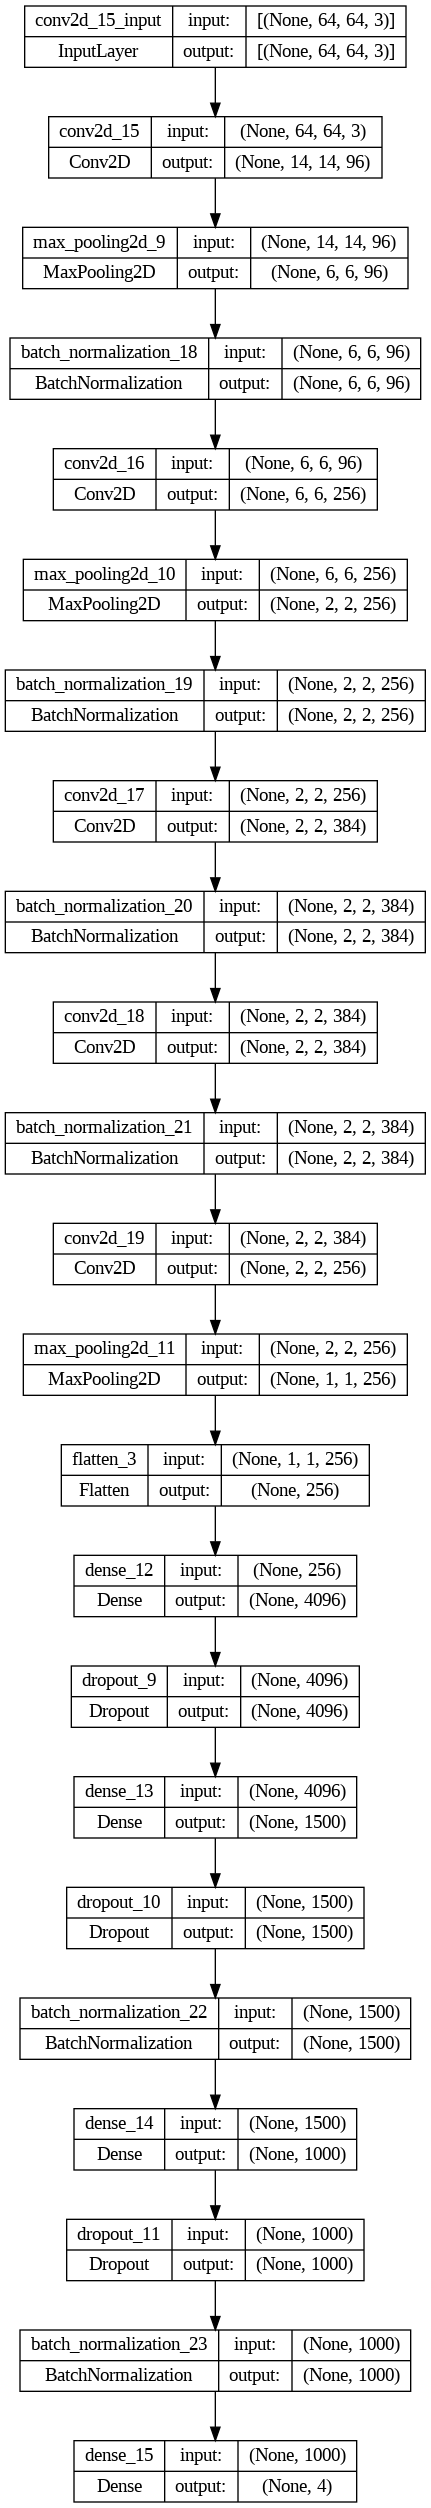

In [ ]:
model = create_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 14, 14, 96)        34944     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 96)          0         
 g2D)                                                            
                                                                 
 batch_normalization_18 (Ba  (None, 6, 6, 96)          384       
 tchNormalization)                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 6, 6, 256)         614656    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 2, 2, 256)         0         
 ng2D)                                                           
                                                      

**INITIATE OPTIMIZER**

In [ ]:
##opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
#model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
#print("[INFO] training network...")

# Define an optimizer with learning rate and other parameters
opt = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Compile your model and specify the optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

**CHECKPOINT CREATING MODEL FOR CROSS VALIDATION**

In [ ]:
filepath="model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size):
    model = create_model()
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    results = model.fit(t_x, t_y,validation_data=(val_x, val_y), epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)
    print("Val Score: ", model.evaluate(val_x, val_y))

    return results

**TRAINING DATA WITH CROSS VALIDATION**

In [ ]:
#save the model history in a list after fitting so that we can plot later
model_history = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs=EPOCHS, batch_size=BS))
print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/100
84/84 [==============================] - ETA: 0s - loss: 1.0080 - accuracy: 0.6670
Epoch 1: val_loss improved from inf to 15.03918, saving model to model.h5
84/84 [==============================] - 48s 552ms/step - loss: 1.0080 - accuracy: 0.6670 - val_loss: 15.0392 - val_accuracy: 0.3358
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/84 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.7637
Epoch 2: val_loss improved from 15.03918 to 1.02978, saving model to model.h5
84/84 [==============================] - 54s 647ms/step - loss: 0.6583 - accuracy: 0.7637 - val_loss: 1.0298 - val_accuracy: 0.6940
Epoch 3/100
42/84 [==============>...............] - ETA: 22s - loss: 0.5066 - accuracy: 0.8080

**RESULT OF TRAINING DATA PROCESS**

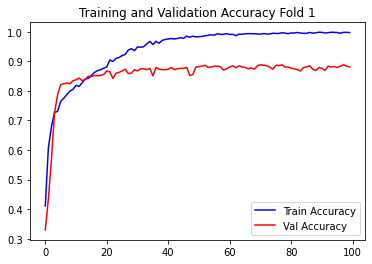

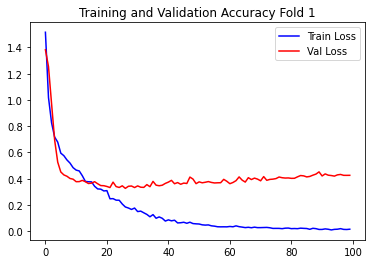

In [ ]:
#FOLD 1
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 1')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 1.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Accuracy Fold 1')
plt.plot(model_history[0].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[0].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 1.jpg")
plt.show()

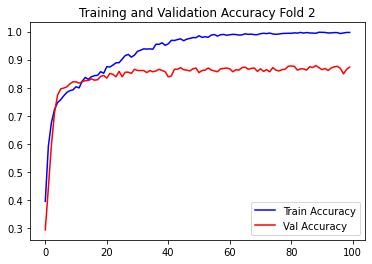

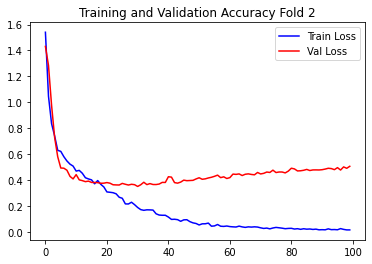

In [ ]:
#FOLD 2
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 2')
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 2.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Accuracy Fold 2')
plt.plot(model_history[1].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[1].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 2.jpg")
plt.show()

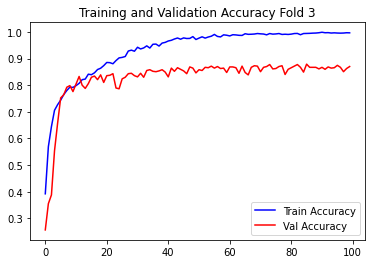

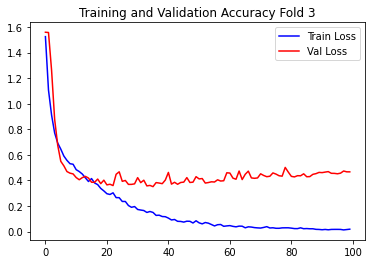

In [ ]:
#FOLD 3
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 3')
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 3.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Accuracy Fold 3')
plt.plot(model_history[2].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[2].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 3.jpg")
plt.show()

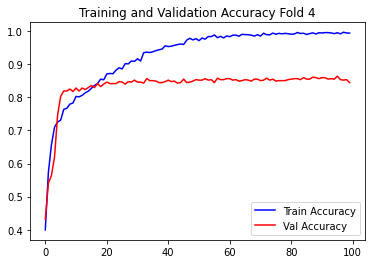

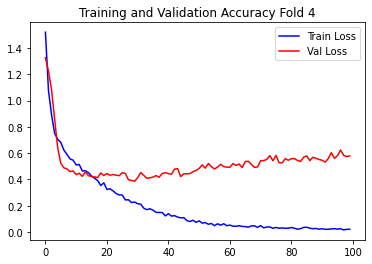

In [ ]:
#FOLD 4
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 4')
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 4.jpg")
plt.show()

plt.figure()

#Train and validation loss
plt.title('Training and Validation Accuracy Fold 4')
plt.plot(model_history[3].history['loss'], label='Train Loss', color='blue', )
plt.plot(model_history[3].history['val_loss'], label='Val Loss', color='red', )
plt.legend()
plt.savefig("Loss_fold 4.jpg")
plt.show()

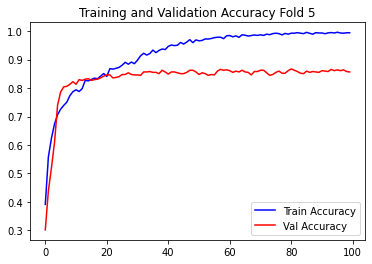

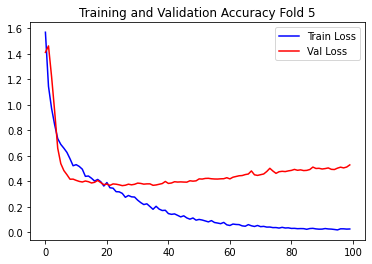

In [ ]:
#FOLD 5
#Train and validation accuracy
plt.title('Training and Validation Accuracy Fold 5')
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy', color='blue', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy', color='red', )
plt.legend()
plt.savefig("Accuracy_fold 5.jpg")
plt.show()

plt.figure()

#Train and validation loss
.

**LOAD BEST MODEL BY RESULT**

In [ ]:
modeltest = load_model('model.h5')

**EVALUATING PARAMETER**

In [ ]:
print("[INFO] evaluating network...")
predictions = modeltest.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=label_binarizer.classes_))

[INFO] evaluating network...
                precision    recall  f1-score   support

        Blight       0.80      0.83      0.81       224
   Common_Rust       0.97      0.92      0.94       299
Gray_Leaf_Spot       0.63      0.63      0.63       114
       Healthy       0.96      0.99      0.97       201

      accuracy                           0.87       838
     macro avg       0.84      0.84      0.84       838
  weighted avg       0.87      0.87      0.87       838



In [ ]:
print("[INFO] Calculating model accuracy")
scores = modeltest.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
27/27 [==============================] - 1s 6ms/step - loss: 0.3580 - accuracy: 0.8723
Test Accuracy: 87.23150491714478


**CONFUSION MATRIX**

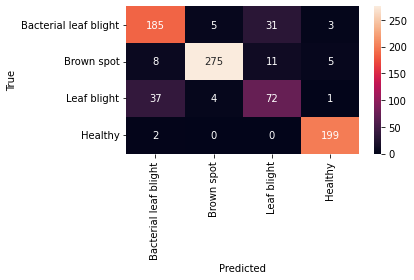

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))
x_axis_labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf blight', 'Healthy']
y_axis_labels = ['Bacterial leaf blight', 'Brown spot', 'Leaf blight', 'Healthy']
sn.heatmap(confusion_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()